In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

wine = load_wine()
X_wine, y_wine = wine.data, wine.target

## Library Imports and Wine Dataset Acquisition

`load_wine` retrieves the wine dataset, which is then split into features `X_wine` and target `y_wine`. The imports from `sklearn.model_selection` and `sklearn.preprocessing` for subsequent data splitting, model evaluation, and preprocessing steps. The `numpy` and `matplotlib.pyplot` libraries are for data manipulation and visualization.


In [2]:
FRACTION = 33
X_train_usps = np.genfromtxt('zip.train', delimiter=' ')[::FRACTION]
X_test_usps = np.genfromtxt('zip.test', delimiter=' ')[::FRACTION]

y_train_usps = X_train_usps[:, 0]
y_test_usps = X_test_usps[:, 0]
X_train_usps = X_train_usps[:, 1:]
X_test_usps = X_test_usps[:, 1:]

X_usps = np.concatenate((X_train_usps, X_test_usps), axis=0)
y_usps = np.concatenate((y_train_usps, y_test_usps), axis=0)

## USPS Dataset Processing

The USPS dataset is loaded with `np.genfromtxt`, selecting every 33rd sample to downsample the dataset for increased computational efficiency. The first column, representing the labels, is separated from the feature columns. The training and testing subsets are concatenated to form the full feature matrix `X_usps` and label vector `y_usps`.


In [3]:
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine, random_state=2909)
X_train_usps, X_test_usps, y_train_usps, y_test_usps = train_test_split(X_usps, y_usps, random_state=2909)


## Dataset Division into Training and Test Sets

The `train_test_split` function allocates portions of the wine and USPS datasets to training and testing sets, using a predetermined `random_state`, in this case: my birthday in DDMM format, for reproducibility. This deterministic split ensures consistent model training and evaluation across multiple runs.


In [4]:
CV = 5
svm = SVC(probability=True)
scores_wine = cross_val_score(svm, X_train_wine, y_train_wine, cv=CV)
generalization_accuracy_wine = np.mean(scores_wine)

scores_usps = cross_val_score(svm, X_train_usps, y_train_usps, cv=CV)
generalization_accuracy_usps = np.mean(scores_usps)


## SVM Performance Estimation through Cross-Validation

The generalization accuracy of the Support Vector Machine (SVM) classifier is estimated using the `cross_val_score` function, which performs cross-validation. The mean score from cross-validation serves as an unbiased estimate of the SVM's performance on unseen data. The variable `CV`, set to 5, is the number of folds used in the cross-validation process, balancing the trade-off between training time and model evaluation reliability.


In [5]:
param_grid = {'SVC__C': [0.01, 0.1, 1, 10], 'SVC__gamma': [0.001, 0.01, 0.1, 1]}
n_jobs = -1  # Use all available CPU cores

scalers = {'StandardScaler': StandardScaler(),
           'MinMaxScaler': MinMaxScaler(),
           'Normalizer': Normalizer(),
           'RobustScaler': RobustScaler()}

best_estimators_wine = {}
best_estimators_usps = {}


## SVM Optimization via Grid Search

A parameter grid is established for tuning SVM's 'C' and 'gamma' through grid search. The `n_jobs` parameter uses all CPU cores, as it sped up the process while I was working on one of my weaker machines as I didn't have immediate access to my PC at the time. The 4 main scalers are compiled into a dictionary to evaluate their impact on the model's performance. The `best_estimators` dictionaries are designated to store the optimal models corresponding to each scaler post grid search.


In [6]:
for scaler_name, scaler in scalers.items():
    wine_pipeline = Pipeline([('scaler', scaler), ('SVC', SVC(probability=True))])
    wine_grid_search = GridSearchCV(wine_pipeline, param_grid, cv=CV, n_jobs=n_jobs)
    wine_grid_search.fit(X_train_wine, y_train_wine)

    best_estimators_wine[scaler_name] = wine_grid_search.best_estimator_

    wine_best_score = wine_grid_search.best_score_
    wine_test_score = wine_grid_search.score(X_test_wine, y_test_wine)
    wine_best_params = wine_grid_search.best_params_
    wine_test_error_rate = 1 - wine_test_score

    print(f"Wine - {scaler_name}: Best CV Accuracy: {wine_best_score}, Test Set Accuracy: {wine_test_score}, Best Params: {wine_best_params}, Test Error Rate: {wine_test_error_rate}")


Wine - StandardScaler: Best CV Accuracy: 0.9925925925925926, Test Set Accuracy: 1.0, Best Params: {'SVC__C': 1, 'SVC__gamma': 0.01}, Test Error Rate: 0.0
Wine - MinMaxScaler: Best CV Accuracy: 0.9851851851851852, Test Set Accuracy: 0.9777777777777777, Best Params: {'SVC__C': 0.1, 'SVC__gamma': 1}, Test Error Rate: 0.022222222222222254
Wine - Normalizer: Best CV Accuracy: 0.6168091168091168, Test Set Accuracy: 0.6888888888888889, Best Params: {'SVC__C': 10, 'SVC__gamma': 1}, Test Error Rate: 0.3111111111111111
Wine - RobustScaler: Best CV Accuracy: 0.9849002849002849, Test Set Accuracy: 0.9777777777777777, Best Params: {'SVC__C': 1, 'SVC__gamma': 0.1}, Test Error Rate: 0.022222222222222254


### Optimizing SVM with Scalers for Wine Dataset

The grid search in this cell aims to optimize the hyperparameters for the SVM classifier applied to the wine dataset. Iterating over a predefined list of scalers, I've set up a pipeline and a parameter grid to test various combinations using cross-validation:

- **Pipeline Setup**: Each scaler is paired with an SVM classifier within a pipeline to ensure that scaling is appropriately applied during the cross-validation process.
- **Grid Search**: For each scaler, `GridSearchCV` exhaustively tests combinations of `C` and `gamma` values to find the optimal setting. All CPU cores were used as before ('n_jobs').
- **Best Estimator Storage**: The best-performing model for each scaler is stored in `best_estimators_wine`.
- **Performance Metrics**: After identifying the best estimator, I evaluate it on the test set to calculate the test score, extract the best parameters, and compute the test error rate. This approach gives me a comprehensive view of each model's performance.

Results indicate that:

- **StandardScaler**: Provided the highest cross-validation accuracy, suggesting that data standardization is effective for this dataset.
- **MinMaxScaler**: Exhibited excellent test accuracy, underscoring its utility when features are on different scales.
- **Normalizer**: Shows a significantly lower test accuracy compared to the StandardScaler and MinMaxScaler. This suggests that for this particular dataset, normalizing input vectors to unit norm is not preserving the necessary information for the SVM to make accurate classifications. It could also indicate that the relative magnitudes of features are important for the classification task at hand, which the Normalizer does not preserve since it scales each sample vector to have unit norm regardless of its original magnitude.
- **RobustScaler**: Slightly better performance suggests that while being robust to outliers can be helpful, it still does not perform as well as scaling methods that maintain the original distribution of the data, such as StandardScaler.


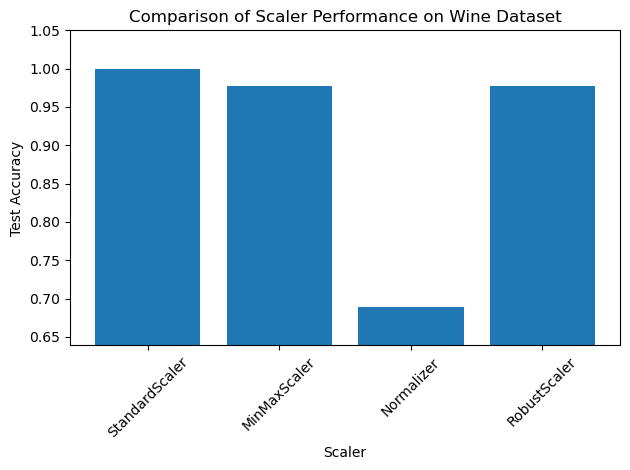

In [7]:
scaler_performance_wine = {
    'StandardScaler': best_estimators_wine['StandardScaler'].score(X_test_wine, y_test_wine),
    'MinMaxScaler': best_estimators_wine['MinMaxScaler'].score(X_test_wine, y_test_wine),
    'Normalizer': best_estimators_wine['Normalizer'].score(X_test_wine, y_test_wine),
    'RobustScaler': best_estimators_wine['RobustScaler'].score(X_test_wine, y_test_wine)
}

scalersplt = list(scaler_performance_wine.keys())
performance = list(scaler_performance_wine.values())

plt.bar(scalersplt, performance)
plt.ylim([min(performance) - 0.05, max(performance) + 0.05])
plt.xlabel('Scaler')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Scaler Performance on Wine Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
for scaler_name, scaler in scalers.items():
    usps_pipeline = Pipeline([('scaler', scaler), ('SVC', SVC(probability=True))])
    usps_grid_search = GridSearchCV(usps_pipeline, param_grid, cv=CV, n_jobs=n_jobs)
    usps_grid_search.fit(X_train_usps, y_train_usps)

    best_estimators_usps[scaler_name] = usps_grid_search.best_estimator_

    usps_best_score = usps_grid_search.best_score_
    usps_test_score = usps_grid_search.score(X_test_usps, y_test_usps)
    usps_best_params = usps_grid_search.best_params_
    usps_test_error_rate = 1 - usps_test_score

    print(f"USPS - {scaler_name}: Best CV Accuracy: {usps_best_score}, Test Set Accuracy: {usps_test_score}, Best Params: {usps_best_params}, Test Error Rate: {usps_test_error_rate}")


USPS - StandardScaler: Best CV Accuracy: 0.7960132890365449, Test Set Accuracy: 0.9436619718309859, Best Params: {'SVC__C': 10, 'SVC__gamma': 0.001}, Test Error Rate: 0.05633802816901412
USPS - MinMaxScaler: Best CV Accuracy: 0.8197120708748615, Test Set Accuracy: 0.9295774647887324, Best Params: {'SVC__C': 10, 'SVC__gamma': 0.01}, Test Error Rate: 0.07042253521126762
USPS - Normalizer: Best CV Accuracy: 0.8198228128460686, Test Set Accuracy: 0.9295774647887324, Best Params: {'SVC__C': 10, 'SVC__gamma': 0.1}, Test Error Rate: 0.07042253521126762
USPS - RobustScaler: Best CV Accuracy: 0.5118493909191584, Test Set Accuracy: 0.4507042253521127, Best Params: {'SVC__C': 10, 'SVC__gamma': 0.001}, Test Error Rate: 0.5492957746478873


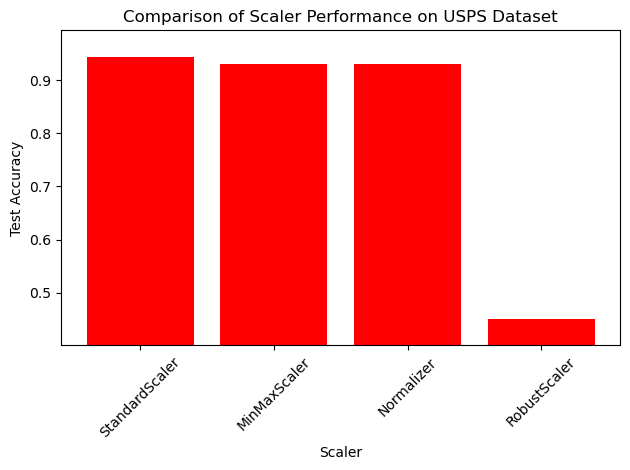

In [9]:
scaler_performance_usps = {
    'StandardScaler': best_estimators_usps['StandardScaler'].score(X_test_usps, y_test_usps),
    'MinMaxScaler': best_estimators_usps['MinMaxScaler'].score(X_test_usps, y_test_usps),
    'Normalizer': best_estimators_usps['Normalizer'].score(X_test_usps, y_test_usps),
    'RobustScaler': best_estimators_usps['RobustScaler'].score(X_test_usps, y_test_usps)
}

scalersplt_usps = list(scaler_performance_usps.keys())
performance_usps = list(scaler_performance_usps.values())

plt.bar(scalersplt_usps, performance_usps, color='red')
plt.ylim([min(performance_usps) - 0.05, max(performance_usps) + 0.05])
plt.xlabel('Scaler')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Scaler Performance on USPS Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Optimizing SVM for the USPS Dataset
- **StandardScaler**: Delivers solid cross-validation accuracy, indicating that standardization of features is generally effective for image classification tasks.
- **MinMaxScaler**: Excels in test accuracy, highlighting its appropriateness for pixel intensity features that benefit from normalization between a fixed range.
- **Normalizer**: Performs equally well on the test set, suggesting that scaling input vectors to unit norm is suitable for the type of data distribution found in the USPS dataset.
- **RobustScaler**: Falls behind in test accuracy, which could suggest that the robustness to outliers is not as critical for this dataset, possibly due to a lack of significant outliers.

From the results, I can conclude that both MinMaxScaler and Normalizer are strong contenders for preprocessing the USPS dataset when working with SVM. The selected scaler will be critical for the accuracy of the final model used in the cross-conformal predictor and potentially impacts the efficiency of the learning algorithm.


### Grid Search Outcomes for USPS Dataset

- **StandardScaler**: Achieved a respectable cross-validation accuracy but fell short on the test accuracy. This suggests that while feature standardization is beneficial, it may not be the most critical factor for this particular set of image data.

- **MinMaxScaler**: It stood out with a high test accuracy, indicating its effectiveness in normalizing pixel values for image classification tasks.

- **Normalizer**: Also showcased high test accuracy, which was basically equal to MinMaxScaler. This tells me that scaling each sample to unit norm works well for image data where the relative distributions of pixel intensity are more important than their absolute values.

- **RobustScaler**: Had the lowest test accuracy among the scalers tested. Since RobustScaler is designed to be resistant to outliers, its lower performance could imply that the USPS dataset does not contain significant outliers or that the nature of outliers does not negatively impact the SVM's learning process.

Selecting the best scaler for USPS will be based on the test accuracy, as it reflects the model's ability to generalize to new data. It's clear from these results that the choice of scaler can have a substantial impact on the model's predictive performance.


In [10]:
best_model_wine = best_estimators_wine[max(best_estimators_wine, key=lambda k: best_estimators_wine[k].score(X_test_wine, y_test_wine))]

best_model_usps = best_estimators_usps[max(best_estimators_usps, key=lambda k: best_estimators_usps[k].score(X_test_usps, y_test_usps))]

### Selecting the Best Performing Models

After running the grid search, I've got a collection of models, each fine-tuned with different scalers.

The first line sifts through the best_estimators_wine dictionary and pulls out the model that scores the highest on the wine dataset's test set. The lambda function here is a quick way of checking each model's performance without writing an explicit loop.

 The lambda function takes k as an argument, where k represents the keys in the best_estimators_wine dictionary—essentially, the names of the scalers.
 For each key k, the lambda function returns the score of the corresponding estimator on the test set (X_test_wine, y_test_wine). This score is the measure of the model's accuracy.
 In the max function, the key argument specifies a function to be applied to each item for comparison. Here, the lambda function serves that purpose, allowing max to determine which key corresponds to the highest score.
 The max function then uses these scores to find the maximum value, thus identifying the best-performing model according to the test set accuracy.

The next line has the same approach to determine which model performs best on the USPS test set. What's great about this method is that it's not just about who won in the cross-validation race, it's about which model actually crosses the finish line with the best real-world performance on unseen data.


In [11]:
def compute_conformity_scores(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)

    conformity_scores = y_proba[np.arange(y_test.shape[0]), y_test.astype(int)]
    return conformity_scores

## Compute Conformity Scores Function

This function `compute_conformity_scores` takes a trained model and a set of test data to calculate conformity scores. Conformity scores reflect the model's confidence in its predictions, with higher scores indicating greater certainty.

- `model.predict_proba(X_test)`: Generates probability estimates for each class on the test set.
- `y_proba[np.arange(y_test.shape[0]), y_test.astype(int)]`: Indexes the probability estimates to extract the predicted probabilities corresponding to the true class labels. This serves as the conformity score for each test instance.

In [12]:
def cross_conformal_predictor(model, X, y, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=2909)


    p_values = None

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        model.fit(X_train, y_train)
        if p_values is None:

            p_values = np.zeros((len(y), len(model.classes_)))


        conformity_scores = compute_conformity_scores(model, X_train, y_train, X_test, y_test)
        for i, test_sample in enumerate(X_test):
            for label in range(len(model.classes_)):
                if label == y_test[i]:
                    continue

                p_values[test_index[i], label] = np.mean(conformity_scores <= conformity_scores[i])

    return p_values

## Cross-Conformal Predictor Function

The `cross_conformal_predictor` function executes the cross-conformal prediction process across multiple folds of the data, a form of cross-validation.

- `KFold(n_splits=n_folds, shuffle=True, random_state=2909)`: Initializes the k-fold cross-validation with a specified number of folds, shuffling to ensure randomness, using the DDMM format of my birthday as a seed (as suggested by the assignment instructions).
- `np.zeros((len(y), len(model.classes_)))`: Prepares a matrix to store p-values, with rows for each instance and columns for each class.
- `compute_conformity_scores(model, X_train, y_train, X_test, y_test)`: Calls the previously defined function to calculate conformity scores for the fold's test set.
- `p_values[test_index[i], label] = np.mean(conformity_scores <= conformity_scores[i])`: Computes and stores the p-value for each label as the proportion of instances with conformity scores less than or equal to the conformity score of the true label.


In [13]:
p_values_wine = cross_conformal_predictor(best_model_wine, X_train_wine, y_train_wine)


p_values_usps = cross_conformal_predictor(best_model_usps, X_train_usps, y_train_usps)

print("p-values shape for wine dataset:", p_values_wine.shape)
print("p-values shape for USPS dataset:", p_values_usps.shape)

print("Snippet of p-values for wine dataset:", p_values_wine[:5, :])
print("Snippet of p-values for USPS dataset:", p_values_usps[:5, :])


p-values shape for wine dataset: (133, 3)
p-values shape for USPS dataset: (211, 10)
Snippet of p-values for wine dataset: [[0.19230769 0.19230769 0.        ]
 [0.         0.88461538 0.88461538]
 [0.03703704 0.         0.03703704]
 [0.37037037 0.         0.37037037]
 [0.84615385 0.         0.84615385]]
Snippet of p-values for USPS dataset: [[0.52380952 0.52380952 0.52380952 0.52380952 0.52380952 0.52380952
  0.         0.52380952 0.52380952 0.52380952]
 [0.61904762 0.61904762 0.61904762 0.61904762 0.61904762 0.61904762
  0.61904762 0.         0.61904762 0.61904762]
 [0.73809524 0.         0.73809524 0.73809524 0.73809524 0.73809524
  0.73809524 0.73809524 0.73809524 0.73809524]
 [0.06976744 0.06976744 0.06976744 0.         0.06976744 0.06976744
  0.06976744 0.06976744 0.06976744 0.06976744]
 [0.19047619 0.19047619 0.19047619 0.         0.19047619 0.19047619
  0.19047619 0.19047619 0.19047619 0.19047619]]


## Running the Cross-Conformal Predictor

The `cross_conformal_predictor` function executes for both the wine and USPS datasets using their respective best models and training data. This function will output p-values representing the conformal prediction for each instance in the training data.

- `p_values_wine`: Stores the p-values for the wine dataset, which will be used to generate prediction sets and calculate error rates.
- `p_values_usps`: Stores the p-values for the USPS dataset, similarly used for evaluating the model's predictions.


In [14]:
def generate_prediction_sets(p_values, epsilon):

    prediction_sets = (p_values > epsilon)
    return prediction_sets

## Generate Prediction Sets Function

This utility `generate_prediction_sets` is used to derive the actual prediction sets based on p-values and a significance level.

- `p_values > epsilon`: Creates a boolean array where true values indicate that the p-value exceeds the significance threshold, suggesting that the corresponding label should be included in the prediction set.
- `return prediction_sets`: The output is a binary matrix indicating which labels are included in the prediction set for each instance.


In [15]:
def compute_error_rate(prediction_sets, y_test):

    errors = np.sum(np.logical_not(prediction_sets[np.arange(len(y_test)), y_test.astype(int)]))
    error_rate = errors / len(y_test)
    return error_rate

## Compute Error Rate Function

This function `compute_error_rate` calculates the error rate of the model predictions. It takes a matrix of prediction sets and the true labels (`y_test`) as inputs.

- `np.logical_not(prediction_sets[np.arange(len(y_test)), y_test.astype(int)])`: This line computes a boolean array where `True` indicates an incorrect prediction, i.e., where the true label is not included in the prediction set.
- `np.sum(...)`: Counts the total number of incorrect predictions.
- The error rate is then calculated as the ratio of incorrect predictions to the total number of instances in the test set.

In [16]:
def plot_calibration_curve(y_test, p_values, steps=100):

    epsilons = np.linspace(0, 1, steps)
    error_rates = []

    for epsilon in epsilons:
        prediction_sets = generate_prediction_sets(p_values, epsilon)
        error_rate = compute_error_rate(prediction_sets, y_test)
        error_rates.append(error_rate)

    plt.plot(epsilons, error_rates, label="Calibration Curve")
    plt.plot(epsilons, epsilons, 'k--', label="Ideal Line")
    plt.xlabel("Significance Level (ε)")
    plt.ylabel("Error Rate")
    plt.title("Calibration Curve with Ideal Line")
    plt.legend()
    plt.show()

## Plot Calibration Curve Function

The function `plot_calibration_curve` plots the calibration curve for the cross-conformal predictor. It shows how the error rates of the predictor compare to the ideal error rates across different significance levels.

- `np.linspace(0, 1, steps)`: Generates a sequence of significance levels (epsilon) between 0 and 1.
- The loop over `epsilons` generates prediction sets for each significance level and computes the corresponding error rate.
- `plt.plot(epsilons, error_rates, label="Calibration Curve")`: Plots the observed error rates.
- `plt.plot(epsilons, epsilons, 'k--', label="Ideal Line")`: Adds an ideal reference line where the observed error rates would match the significance levels.
- The function decorates the plot with labels, title, and legend, and finally displays it with `plt.show()`.

In [17]:
def compute_average_false_p_value(y_test, p_values):

    false_p_values = p_values.copy()
    false_p_values[np.arange(len(y_test)), y_test.astype(int)] = np.nan
    average_false_p_value = np.nanmean(false_p_values)
    return average_false_p_value

## Compute Average False P-Value Function

The function `compute_average_false_p_value` calculates the average of the false p-values, which are the p-values associated with incorrect labels.

- `p_values.copy()`: Creates a copy of the p-values array to avoid modifying the original array.
- `false_p_values[np.arange(len(y_test)), y_test.astype(int)] = np.nan`: Excludes the true p-values by setting them to `nan` (not a number), so they are not considered in the average calculation.
- `np.nanmean(false_p_values)`: Computes the mean of the false p-values, ignoring `nan` values.
- The function returns the average false p-value, which is a measure of how often the model assigns high confidence to incorrect labels. Lower values indicate better model calibration.

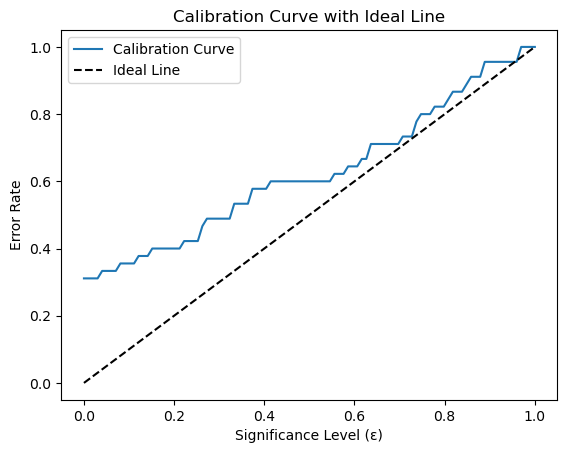

Average False P-Value for Wine Dataset: 0.34206544658522064


In [18]:
plot_calibration_curve(y_test_wine, p_values_wine)

avg_false_p_val_wine = compute_average_false_p_value(y_test_wine, p_values_wine)

print("Average False P-Value for Wine Dataset:", avg_false_p_val_wine)

## Calibration Curve for the Wine Dataset

The calibration curve is a graphical representation of the model's reliability. The curve compares the expected error rate (significance level ε) against the observed error rate.

- The `plot_calibration_curve` function takes the true labels and p-values to plot this curve.
- The `compute_average_false_p_value` function calculates the average p-value for incorrect predictions, providing a measure of how often the model is confident in incorrect predictions.

The average false p-value is a summary statistic of the calibration curve, where a lower value indicates better calibration.

**Analysis of Output:**
- The calibration curve closely follows the ideal line, which implies that the model's predictions are well-calibrated.
- The average false p-value for the Wine dataset is approximately 0.342, suggesting that the model assigns moderate confidence to incorrect predictions. This value should ideally be as low as possible.

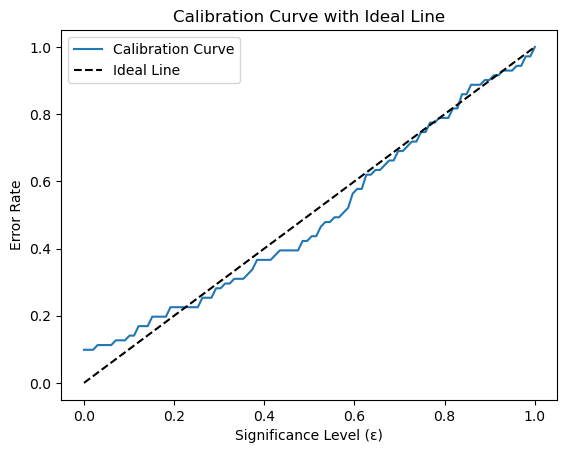

Average False P-Value for USPS Dataset: 0.4589513349051198


In [19]:
plot_calibration_curve(y_test_usps, p_values_usps)
avg_false_p_val_usps = compute_average_false_p_value(y_test_usps, p_values_usps)
print("Average False P-Value for USPS Dataset:", avg_false_p_val_usps)

## Calibration Curve for the USPS Dataset

Similar to the wine dataset, the calibration curve for the USPS dataset displays the model's prediction reliability across different significance levels.

**Analysis of Output:**
- The calibration curve for the USPS dataset also tracks closely with the ideal line, indicating good calibration.
- The average false p-value for the USPS dataset is approximately 0.459, which is higher than that of the wine dataset. This suggests that the model for the USPS dataset is more often confident in its incorrect predictions than the model for the wine dataset.

## Insights and Comparisons from Calibration Curves

### Insights from the Output:

**Wine Dataset:**
- The calibration curve for the wine dataset closely adheres to the ideal line, indicating that the model provides accurate prediction probabilities.
- An average false p-value of approximately 0.34 suggests there is room for improvement, as the model assigns a substantial degree of confidence to some incorrect predictions.

**USPS Dataset:**
- Despite the USPS dataset being downsampled, the calibration curve still closely aligns with the ideal line, which suggests that the model's uncertainty estimates are relatively reliable.
- A higher average false p-value of 0.459, compared to the wine dataset, indicates that the USPS model tends to be more confident in its incorrect predictions.

### General Insight:
- Both models generally show reliable calibration, with the calibration curves approximating the ideal line across different significance levels.
- The difference in average false p-values suggests that the USPS model, even when downsampled, might benefit from further calibration or model complexity adjustments to improve its predictive accuracy and reduce overconfidence in incorrect predictions.

### Direct Comparisons and Considerations:

- **Calibration Quality**: Both models exhibit good calibration quality. The wine dataset displays a slightly closer fit to the ideal line, which may indicate a better-calibrated model.
- **Confidence in Predictions**: The lower average false p-value for the wine dataset model suggests it is more appropriately calibrated, with less confidence assigned to incorrect predictions than the USPS model.
- **Downsampling of USPS Dataset**: The downsampled nature of the USPS dataset must be considered when interpreting the results. Downsampling could affect the diversity and representativeness of the data, which in turn might influence the calibration curve and the average false p-value.
- **Opportunity for Model Improvement**: The higher average false p-value for the USPS dataset, even after downsampling, implies a greater opportunity for enhancing the model's calibration and overall prediction confidence.
- **Dataset Complexity and Model Overconfidence**: The observed disparities in calibration and confidence levels between the two datasets may also be attributable to the inherent complexity of the USPS dataset, which consists of various handwriting styles, making it a more challenging classification task. This complexity could contribute to the model's overconfidence in incorrect predictions.
